 **Importing libraries**

In [ ]:
import pandas as pd
from pip._internal import main as install
install(["install","ta-lib"])
import matplotlib as plt
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import numpy as np
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
from yahoofinancials import YahooFinancials

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached TA-Lib-0.4.24.tar.gz (269 kB)


  ERROR: Failed building wheel for ta-lib


  Running setup.py clean for ta-lib
Failed to build ta-lib
    Running setup.py install for ta-lib: started
    Running setup.py install for ta-lib: finished with status 'error'


ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-fibjqp1k/ta-lib_d7921b53b8d94a2e8db1b886f03d1a8b/setup.py'"'"'; __file__='"'"'/tmp/pip-install-fibjqp1k/ta-lib_d7921b53b8d94a2e8db1b886f03d1a8b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-roj6l7cb/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/ta-lib Check the logs for full command output.


In [ ]:
!pip install yfinance

In [ ]:
!pip install YahooFinancials

**Importing the Data**

In [ ]:
yahoo_financials = YahooFinancials('AAPL')
data = yahoo_financials.get_historical_price_data(start_date='2019-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='weekly')
aapl_df = pd.DataFrame(data['AAPL']['prices'])

# aapl_df['Date'] = aapl_df.loc[:, 'formatted_date']
aapl_df = aapl_df.drop('date', axis=1).set_index('formatted_date')
aapl_df.head()

,high,low,open,close,volume,adjclose,Date
formatted_date,,,,,,,
2019-01-01,39.712502,35.500000,38.722500,36.982498,966947200,35.856091,2019-01-01
2019-01-08,38.632500,37.130001,37.389999,37.500000,725470000,36.357834,2019-01-08
2019-01-15,39.470001,37.512501,37.567501,39.205002,491411200,38.010899,2019-01-15
2019-01-22,39.532501,37.924999,39.102501,39.075001,554774800,37.884865,2019-01-22
2019-01-29,42.915001,38.527500,39.062500,42.812500,830400800,41.508514,2019-01-29


**Cleaning the data**

In [ ]:
aapl_df.isnull().sum()

high        0
low         0
open        0
close       0
volume      0
adjclose    0
Date        0
dtype: int64



*   There are no null values present in our dataset. But if there are any null value s preset we can fill those places with any other value using the fillna() function of DataFrame.Following is the syntax of fillna() function:



In [ ]:
aapl_df.duplicated().sum()

0

**Detecting Outliers**


*   Z-Score
*   Scatter Plots
*   Interquartile range(IQR)

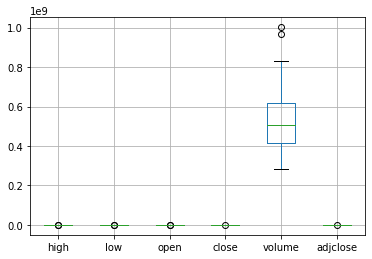

In [ ]:
numerical_col = ['high','low','open',	'close', 'volume','adjclose']
aapl_df.boxplot(numerical_col)

*   As seen above, the variable ‘Volume’ contains outliers which lie above the lower bound.

In [ ]:
for x in ['volume']:
    q75,q25 = np.percentile(aapl_df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    aapl_df.loc[aapl_df[x] < min,x] = np.nan
    aapl_df.loc[aapl_df[x] > max,x] = np.nan

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


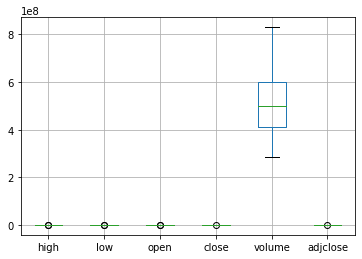

In [ ]:
aapl_df.boxplot(numerical_col)

**Data Transformation**

**Simple Moving Average (SMA)**



1.   Simple Moving Average is one of the core technical indicators used by traders and investors for the technical analysis of a stock, index or securities.
2.   Simple moving average is calculated by adding the closing price of last n number of days and then diving by the number of days(time-period).

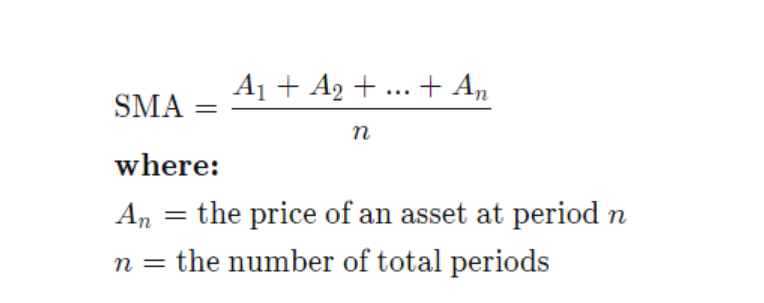

In [ ]:
# create 20 days simple moving average column
aapl_df['20_SMA'] =   aapl_df['close'].rolling(window = 20, min_periods = 1).mean()
# create 50 days simple moving average column
aapl_df['50_SMA'] =   aapl_df['close'].rolling(window = 50, min_periods = 1).mean()

# display first few rows
df_new = aapl_df.iloc[:, [3,6,7,8]]
df_new.head()

,close,Date,20_SMA,50_SMA
formatted_date,,,,
2019-01-01,36.982498,2019-01-01,36.982498,36.982498
2019-01-08,37.500000,2019-01-08,37.241249,37.241249
2019-01-15,39.205002,2019-01-15,37.895833,37.895833
2019-01-22,39.075001,2019-01-22,38.190625,38.190625
2019-01-29,42.812500,2019-01-29,39.115000,39.115000


**Generating buy/sell signals**

In [ ]:
df_new['Signal'] = 0.0
df_new['Signal'] = np.where(df_new['20_SMA'] > df_new['50_SMA'], 1.0, 0.0)
df_new['Position'] = df_new['Signal'].diff()
# df_new.insert(5, "Date", ['formatted_date'], True)
# display first few rows

df_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,close,Date,20_SMA,50_SMA,Signal,Position
formatted_date,,,,,,
2019-01-01,36.982498,2019-01-01,36.982498,36.982498,0.0,NaN
2019-01-08,37.500000,2019-01-08,37.241249,37.241249,0.0,0.0
2019-01-15,39.205002,2019-01-15,37.895833,37.895833,0.0,0.0
2019-01-22,39.075001,2019-01-22,38.190625,38.190625,0.0,0.0
2019-01-29,42.812500,2019-01-29,39.115000,39.115000,0.0,0.0




*   When ‘Position’ = 1, it implies that the Signal has changed from 0 to 1 meaning a short-term(faster) moving average has crossed above the long-term(slower) moving average, thereby triggering a buy call.
*   When ‘Position’ = -1, it implies that the Signal has changed from 1 to 0 meaning a short-term(faster) moving average has crossed below the long-term(slower) moving average, thereby triggering a sell call.



In [ ]:
!pip install signal-backtester

In [ ]:
AAPL_df = df_new.to_csv("aapl_df_bt.csv")

**Setup Backtest**

In [ ]:
# #here is the backtest
# from signal_backtester import SignalBacktester
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/ML/Data")
# os.listdir()
# dataset_address = "Aaapl_df_bt.csv"

# backtest = SignalBacktester(
#     dataset=dataset_address,
#     strategy="two_side_sl_tp_reversed",
#     cash=100000,
#     commission=0.0005,
#     percent_of_portfolio=99,
#     stop_loss=1,
#     take_profit=2,
#     trailing_stop=3,
#     output_path="results",  # path of result files
# )

# backtest.run()


In [ ]:
!pip install backtesting

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 20)
        self.ma2 = self.I(SMA, price, 50)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='5013', ...)

**Visualize the result**

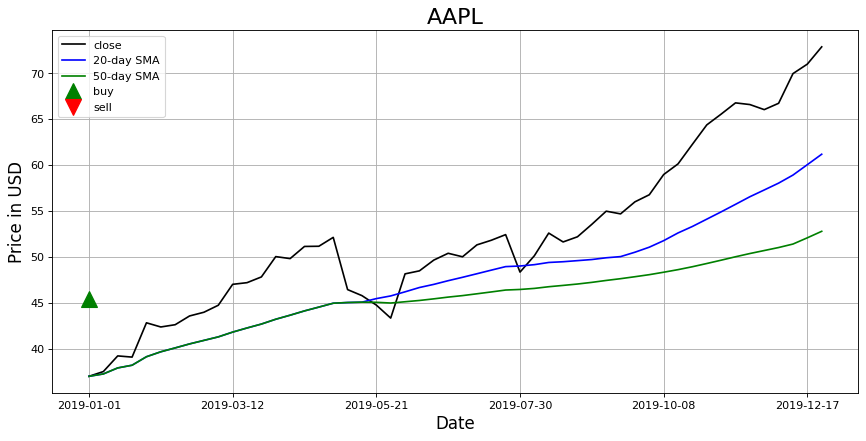

In [ ]:
figure(figsize=(13, 6), dpi=80)
# plot close price, short-term and long-term moving averages 
df_new['close'].plot(color ='k', label= 'close') 
df_new['20_SMA'].plot(color = 'b',label = '20-day SMA') 
df_new['50_SMA'].plot(color = 'g', label = '50-day SMA')
# plot ‘buy’ signals
plt.plot(df_new[df_new['Position'] == 1].index, 
         df_new['20_SMA'][df_new['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(df_new[df_new['Position'] == -1].index, 
         df_new['20_SMA'][df_new['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('AAPL', fontsize = 20)
plt.legend()
plt.grid()
plt.show()



*   As I tried to see in the above plot, 

*   the blue line represents the faster moving average(20 day SMA), 

*   the green line represents the slower moving average(50 day SMA) and   the black line represents the actual closing price.
*   If we carefully observe, these moving averages are nothing but the smoothed versions of the actual price, but lagging by certain period of time. 
*   The short-term moving average closely resembles the actual price which perfectly makes sense as it takes into consideration more recent prices. In contrast, 
*   the long-term moving average has comparatively more lag and loosely resembles the actual price curve.



 **Exponential Moving Average**

 It is straightforward to observe that SMA time-series are much less noisy than the original price. However, this comes at a cost — SMA lag the original price, which means that changes in the trend are only seen with a delay of L days. How much is this lag L? For a SMA moving average calculated using M days, the lag is roughly around M/2 days. Thus, if we are using a 50 days SMA, this means we may be late by almost 25 days, which can significantly affect our strategy.



*   One way to reduce the lag induced by the use of the SMA is to use Exponential Moving Average(EMA). 
*   Exponential moving averages give more weight to the most recent periods.
*   This makes them more reliable than SMAs as they are comparatively better representation of the recent performance of the asset
*   The EMA is calculated as:

            EMA [today] = (α x Price [today] ) + ((1 — α) x EMA [yesterday] )

Where:
α = 2/(N + 1)
N = the length of the window (moving average period)
EMA [today] = the current EMA value
Price [today] = the current closing price
EMA [yesterday] = the previous EMA value



Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


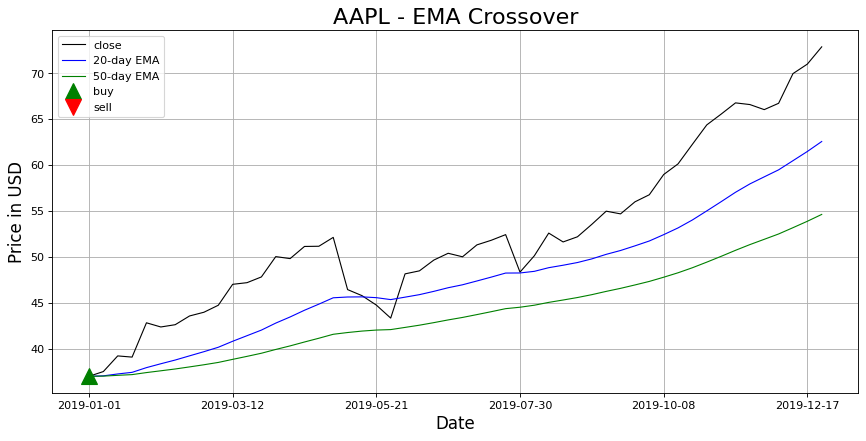

In [ ]:
# set start and end dates 
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 12, 31)
# Create 20 days exponential moving average column
aapl_df['20_EMA'] = aapl_df['close'].ewm(span = 20, adjust = False).mean()
# Create 50 days exponential moving average column
aapl_df['50_EMA'] = aapl_df['close'].ewm(span = 50, adjust = False).mean()
# create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
  
aapl_df['Signal'] = 0.0  
aapl_df['Signal'] = np.where(aapl_df['20_EMA'] > aapl_df['50_EMA'], 1.0, 0.0)

# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column

aapl_df['Position'] = aapl_df['Signal'].diff()
figure(figsize=(13, 6), dpi=80)

# plot close price, short-term and long-term moving averages 
aapl_df['close'].plot(color = 'k', lw = 1, label = 'close')  
aapl_df['20_EMA'].plot(color = 'b', lw = 1, label = '20-day EMA') 
aapl_df['50_EMA'].plot(color = 'g', lw = 1, label = '50-day EMA')

# plot ‘buy’ signals

plt.plot(aapl_df[aapl_df['Position'] == 1].index, 
         aapl_df['20_EMA'][aapl_df['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')

# plot 'sell' signals

plt.plot(aapl_df[aapl_df['Position'] == -1].index, 
         aapl_df['20_EMA'][aapl_df['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('AAPL - EMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

**Model**